## Import thư viện

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import seaborn as sns

## Đọc file

In [3]:
df1 = pd.read_csv('FPT.csv')
df2 = pd.read_csv('MSN.csv')
df3 = pd.read_csv('VIC.csv')
df4 = pd.read_csv('PNJ.csv')

## Preprocessing 

In [14]:
print(df1.info())
print(df2.info())
print(df3.info())
print(df4.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97405 entries, 2018-12-25 09:16:00 to 2020-12-22 14:46:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97405 non-null  object 
 1   Open           97405 non-null  float64
 2   High           97405 non-null  float64
 3   Low            97405 non-null  float64
 4   Close          97405 non-null  float64
 5   Volume         97405 non-null  int64  
 6   Open Interest  97405 non-null  int64  
 7   Volatility     97405 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 6.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135353 entries, 2017-12-25 09:16:00 to 2020-12-22 14:46:00
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135353 non-null  object 
 1   Open           135353 non-null  float64
 2   High           135353

## EDA

Text(0.5, 1.0, 'Biểu đồ tương quan giá Close của 4 cổ phiếu')

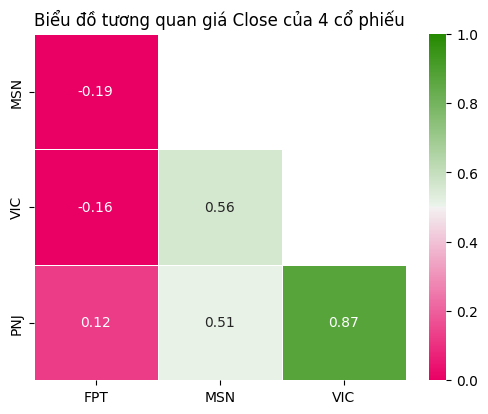

In [19]:
# Chuyển cột Date/Time thành kiểu datetime và đặt làm index
# for df in [df1, df2, df3, df4]:
#     df['Date/Time'] = pd.to_datetime(df['Date/Time'])
#     df.set_index('Date/Time', inplace=True)

# Tạo một DataFrame mới chứa giá đóng cửa của cả 4 cổ phiếu
close_prices = pd.DataFrame({
    'FPT': df1['Close'],
    'MSN': df2['Close'],
    'VIC': df3['Close'],
    'PNJ': df4['Close']
})

# Tạo correlation giữa các cổ phiếu
df_corr = close_prices.corr()
ones_corr = np.ones_like(df_corr, dtype=bool)
mask = np.triu(ones_corr)
adjusted_mask = mask[1:, :-1]
adjusted_dsts_corr = df_corr.iloc[1:, :-1]
adjusted_dsts_corr

plt.figure(figsize=(6,4.5))
cmap = sns.diverging_palette(0, 125,100,50, as_cmap=True)
sns.heatmap(data=adjusted_dsts_corr, mask=adjusted_mask, cmap=cmap,
        vmin=0, vmax=1, linecolor="white", linewidths=0.5,annot=True, fmt=".2f") 
plt.title('Biểu đồ tương quan giá Close của 4 cổ phiếu')

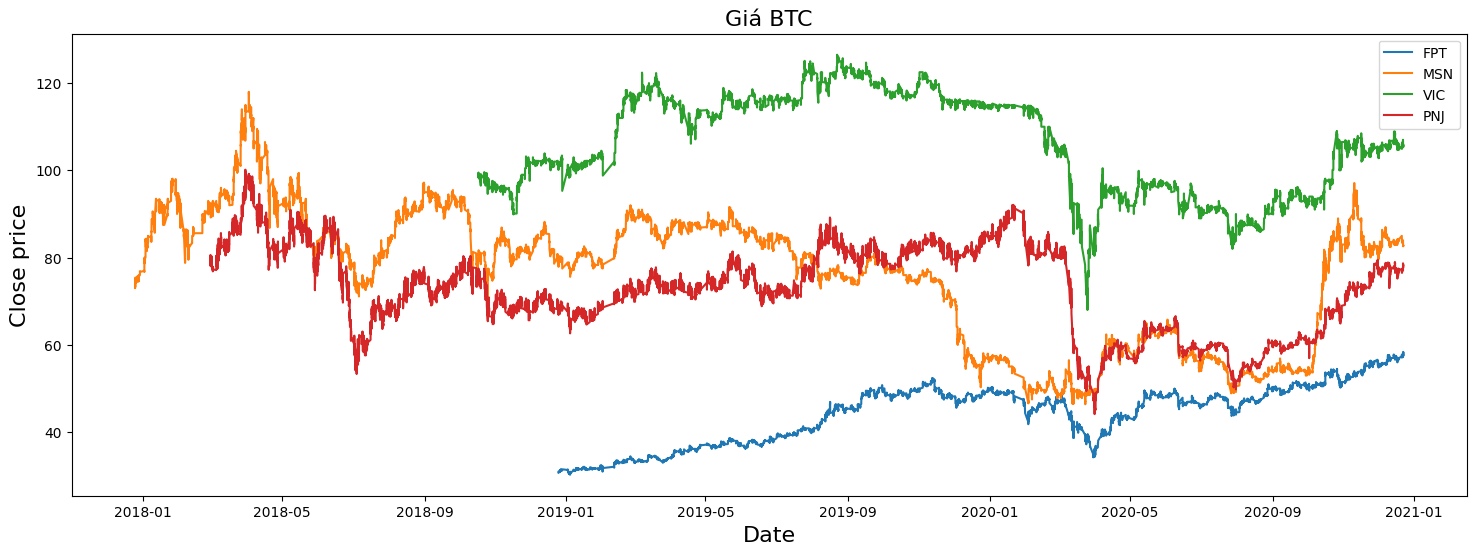

In [6]:
plt.figure(figsize=(18,6))
plt.plot(df1.index, df1['Close'], lw=1.5, label='FPT')
plt.plot(df2.index, df2['Close'], lw=1.5, label='MSN')
plt.plot(df3.index, df3['Close'], lw=1.5, label='VIC')
plt.plot(df4.index, df4['Close'], lw=1.5, label='PNJ')
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close price", fontsize=16)
plt.title("Giá BTC", fontsize=16)
plt.legend()
plt.show();

Thêm feature biến động giá (volatility = giá ngày hôm nay - giá ngày hôm trước)

In [7]:
for df in [df1, df2, df3, df4]:
    df['Volatility'] = df['Close'].diff()
    df.dropna(inplace=True)

### Phân tích biến động giá

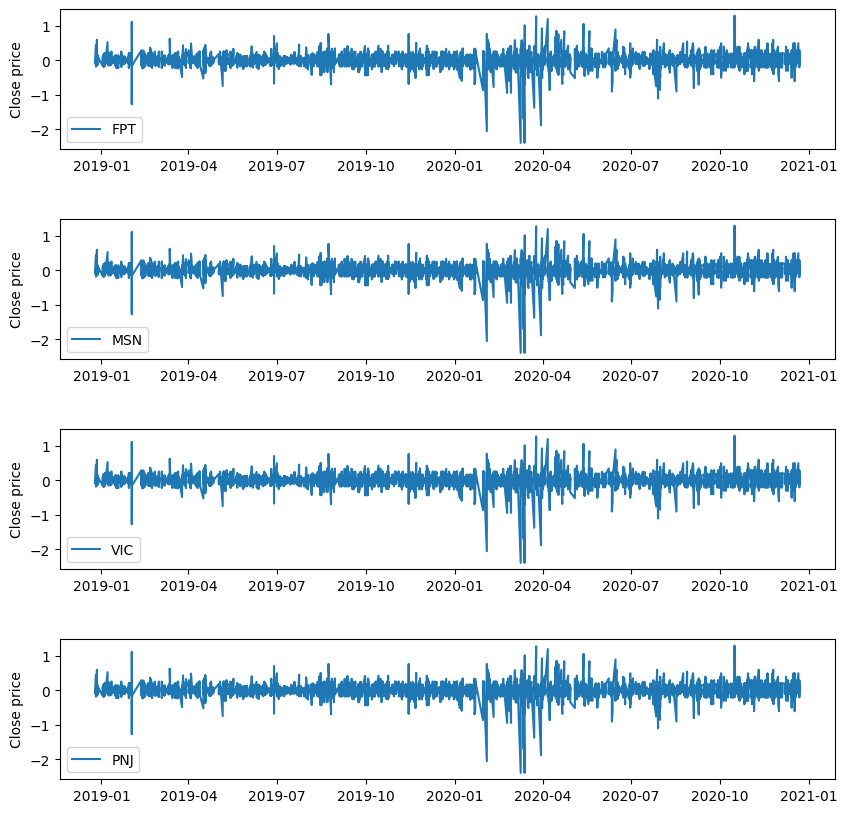

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
axs[0].plot(df1.index, df1['Volatility'], label='FPT')
axs[0].set_ylabel("Close price")
axs[0].legend()

axs[1].plot(df1.index, df1['Volatility'], label='MSN')
axs[1].set_ylabel("Close price")
axs[1].legend()

axs[2].plot(df1.index, df1['Volatility'], label='VIC')
axs[2].set_ylabel("Close price")
axs[2].legend()

axs[3].plot(df1.index, df1['Volatility'], label='PNJ')
axs[3].set_ylabel("Close price")
axs[3].legend()

plt.subplots_adjust(hspace=0.5)
plt.show();

Tất cả cổ phiếu có sự biến động đáng kể, đặc biệt là trong năm 2020.

Có thể trong năm 2020 liên quan đến sự kiện lớn (đại dịch Covid-19)

In [9]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_predict

# Hàm kiểm tra chuỗi dừng
def check_stationarity(timeseries, label):
    result = adfuller(timeseries)
    print(f'Results of Dickey-Fuller Test for {label}:')
    print('Test Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print(f'{label} là chuỗi dừng.\n')
    else:
        print(f'The {label} không phải là chuỗi dừng.\n')

check_stationarity(df1['Volatility'], 'FPT')
check_stationarity(df2['Volatility'], 'MSN')
check_stationarity(df3['Volatility'], 'VIC')
check_stationarity(df4['Volatility'], 'PNJ')

Results of Dickey-Fuller Test for FPT:
Test Statistic: -62.64723386233625
p-value: 0.0
Critical Values: {'1%': -3.4304171569215383, '5%': -2.8615696822983607, '10%': -2.5667857988503013}
FPT là chuỗi dừng.

Results of Dickey-Fuller Test for MSN:
Test Statistic: -42.527080237753175
p-value: 0.0
Critical Values: {'1%': -3.430398340275199, '5%': -2.8615613657056933, '10%': -2.566781372206806}
MSN là chuỗi dừng.

Results of Dickey-Fuller Test for VIC:
Test Statistic: -44.20652486393707
p-value: 0.0
Critical Values: {'1%': -3.430414615396987, '5%': -2.8615685589968916, '10%': -2.566785200954047}
VIC là chuỗi dừng.

Results of Dickey-Fuller Test for PNJ:
Test Statistic: -62.31847790124733
p-value: 0.0
Critical Values: {'1%': -3.4304022047979, '5%': -2.861563073754065, '10%': -2.566782281342949}
PNJ là chuỗi dừng.



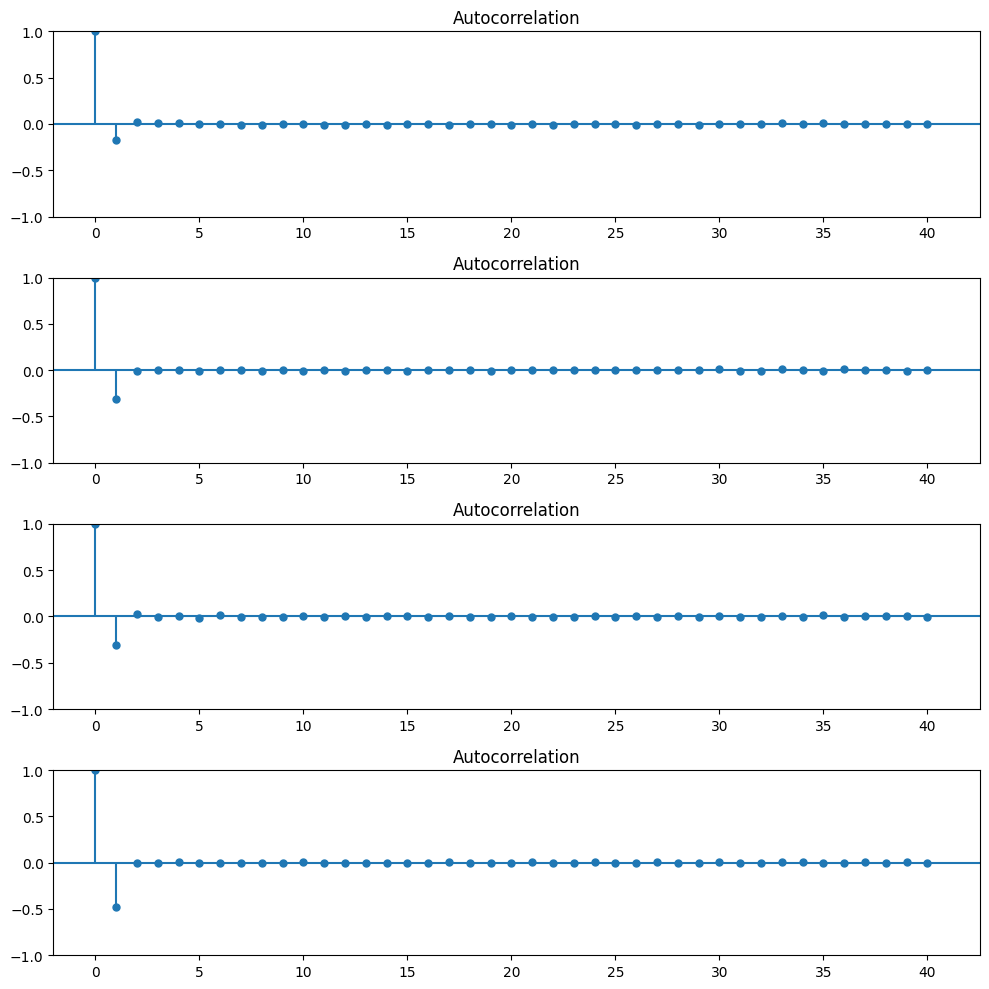

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

# Hàm vẽ đồ thị tự hồi quy cho từng DataFrame
def plot_acf_all(datasets, lags=40):
    fig, axs = plt.subplots(len(datasets), 1, figsize=(10,10))
    for i, data in enumerate(datasets):
        plot_acf(data['Volatility'], lags=lags, ax=axs[i])
    plt.tight_layout()
    plt.show()

# Gọi hàm với các DataFrame và nhãn tương ứng
plot_acf_all([df1, df2, df3, df4])

* Tự tương quan ở độ trễ 0: Trong cả ba biểu đồ, tự tương quan ở độ trễ 0 là 1, điều này là hiển nhiên vì nó đại diện cho sự tương quan của chuỗi dữ liệu với chính nó.

* Độ trễ sau đó: Đối với cả ba biểu đồ, tự tương quan nhanh chóng giảm xuống các giá trị xấp xỉ 0 cho các độ trễ sau đó, điều này cho thấy rất ít hoặc không có sự tương quan ngoài độ trễ ban đầu.

## Train test split

In [66]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

def tts(data, n_lookback, n_forecast):
    # Độ dài chuỗi đầu vào (lookback period)
    # Độ dài chuỗi đầu ra (forecast period)
    y_ = data['Volatility'].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    y_ = scaler.fit_transform(y_)
    
    X, Y = [], []

    for i in range(n_lookback, len(y_) - n_forecast + 1):
        X.append(y_[i - n_lookback : i])
        Y.append(y_[i : i + n_forecast])
    X, Y = np.array(X), np.array(Y)

    # Chia tập dữ liệu (train 80%, test 20%)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Chuyển đổi numpy arrays sang PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).squeeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.float32).squeeze(-1)

    # Tạo DataLoaders cho PyTorch
    train_dataset = TensorDataset(X_train, Y_train)
    test_dataset = TensorDataset(X_test, Y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader, scaler

In [67]:
train_loader_fpt, test_loader_fpt, scaler_fpt = tts(df1, 120, 200)
train_loader_msn , test_loader_msn, scaler_msn = tts(df2, 120, 200)   
train_loader_vic , test_loader_vic, scaler_vic = tts(df3, 120, 200)   
train_loader_pnj , test_loader_pnj, scaler_pnj = tts(df4, 120, 200)   

In [68]:
m  = iter(train_loader_fpt)
c,b = next(m)
print(c.shape)
print(b.shape)

torch.Size([32, 120, 1])
torch.Size([32, 200])


## Pytorch

In [50]:
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [72]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [73]:
def training_loop(model, train_loader, test_loader, num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    all_train_losses = []  
    all_test_losses = []  
    best_accuracy = 0.0 
    best_model_state_dict = None  # Lưu trữ tham số của mô hình tốt nhất
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Đánh giá sau mỗi epoch
        model.eval()
        test_losses = []
        test_accuracy = 0.0  
        with torch.no_grad():
            for X_batch, Y_batch in test_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                Y_pred = model(X_batch)
                loss = criterion(Y_pred, Y_batch)
                test_losses.append(loss.item())
                test_accuracy += loss.item()
                
        # Cập nhật mô hình tốt nhất nếu độ chính xác hiện tại tốt hơn (Earling stop)
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model_state_dict = model.state_dict()  # Lưu trữ tham số mô hình
        
        train_loss_avg = np.mean(train_losses)
        test_loss_avg = np.mean(test_losses)
        
        # Lưu trữ loss trung bình của mỗi epoch
        all_train_losses.append(train_loss_avg)
        all_test_losses.append(test_loss_avg)

        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, num_epochs, train_loss_avg, test_loss_avg))

    return all_train_losses, all_test_losses, best_model_state_dict  

In [74]:
model_lstm = LSTM(1, 50, 3, 200)
model_lstm.to(device)

LSTM(
  (lstm): LSTM(1, 50, num_layers=3, batch_first=True)
  (fc): Linear(in_features=50, out_features=200, bias=True)
)

In [71]:
train_losses, test_losses, best_model = training_loop(model_lstm, train_loader_fpt, test_loader_fpt, num_epochs=200)

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

KeyboardInterrupt: 

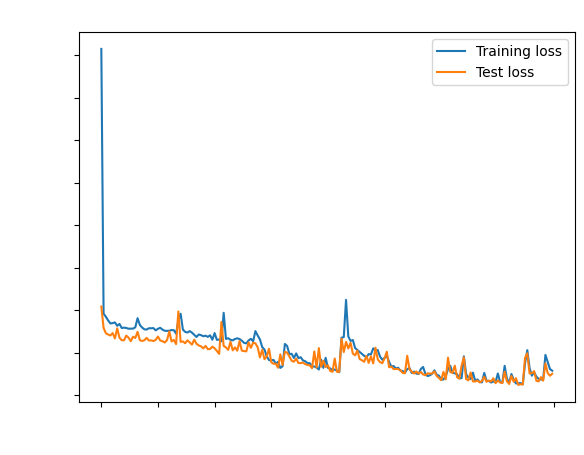

In [57]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epochs', color='white')
plt.xticks(color='white')  # Change tick color to 'green'
plt.ylabel('Y-axis', color='white')
plt.ylabel('Loss')
plt.yticks(color='white')  # Change tick color to 'green'
plt.title("Loss_train_test(1,50,5,120)", color='white')
plt.legend()
plt.savefig('loss(1,50,3,120).png', dpi=300, bbox_inches='tight', transparent=True);
plt.show()

### Predict model

In [58]:
model_lstm = LSTM(1, 50, 3, 120)
model_lstm.to(device)
model_lstm.load_state_dict(best_model)

<All keys matched successfully>

In [ ]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

#  Create Table
Tạo bảng chứa kết quả dự đoán của sequence n_forecast theo date của sequence

In [104]:
def creat_dataframe(data, y_pre):
    df_past = data.reset_index().rename(columns={'Close': 'Price'})
    df_past['Date'] = pd.to_datetime(df_past['Date'])

    # dữ liệu tương lai
    df_future = pd.DataFrame({
        'Date': pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast),
        'Price': y_pre.flatten()
    })

    results = pd.concat([df_past, df_future], ignore_index=True)
    results['Price'] = results['Price'].astype(float)
    return results

**Tensorflow**

In [106]:
data_tensor = creat_dataframe(df['Close'], Y_)

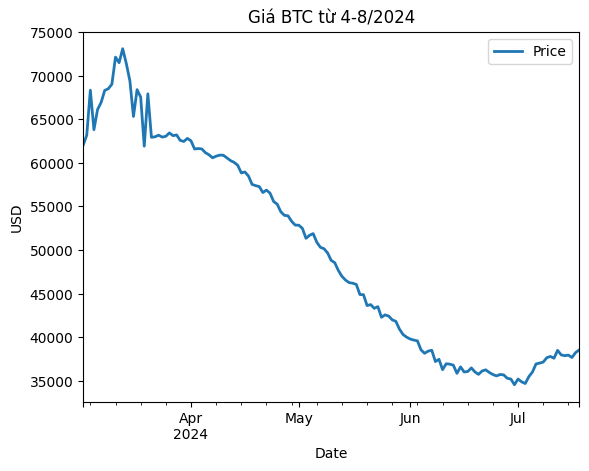

In [107]:
data_tensor[data_tensor['Date'] > '2024-03-01'].plot(x='Date', y = 'Price', lw=2)
plt.ylabel('USD')
plt.title('Giá BTC từ 4-8/2024')
plt.savefig('lstm(1,50,3,120).png', dpi=300, bbox_inches='tight', transparent=True)

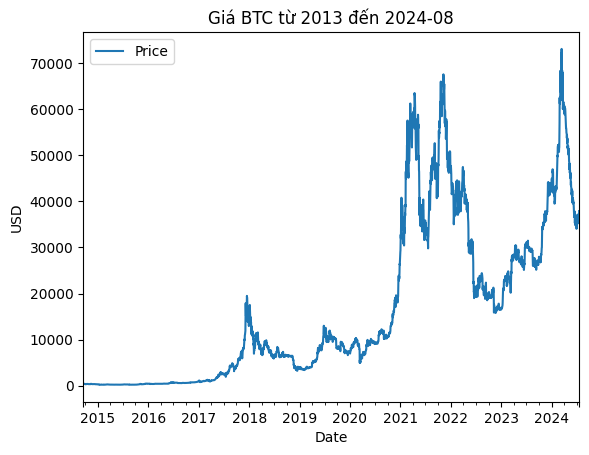

In [88]:
data_tensor.plot(x='Date', y='Price')
plt.ylabel('USD')
plt.title('Giá BTC từ 2013 đến 2024-08');

**Pytorch**

In [60]:
data_pytorch = creat_dataframe(df['Close'], y_predict)

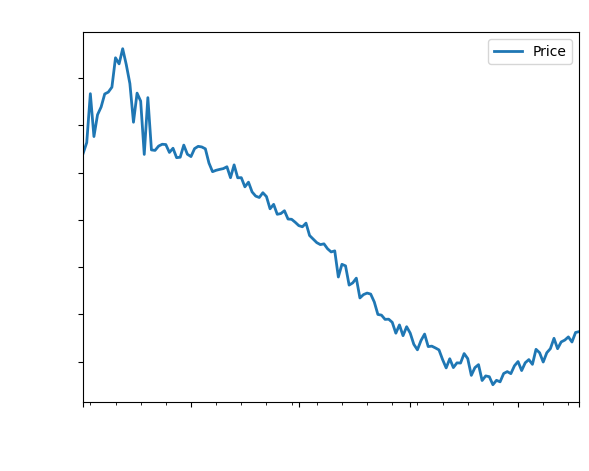

In [61]:
data_pytorch[data_pytorch['Date'] > '2024-03-01'].plot(x='Date', y = 'Price', lw=2)
plt.xlabel("Date", color='white')
plt.xticks(color='white')  # Change tick color to 'green'
plt.ylabel('Loss', color = 'white')
plt.yticks(color='white')  # Change tick color to 'green'
plt.title("Giá BTC từ 4-8/2024(1,50,5,120)", color='white')
plt.ylabel('USD')
plt.savefig('lstm(1,50,3,120).png', dpi=300, bbox_inches='tight', transparent=True)

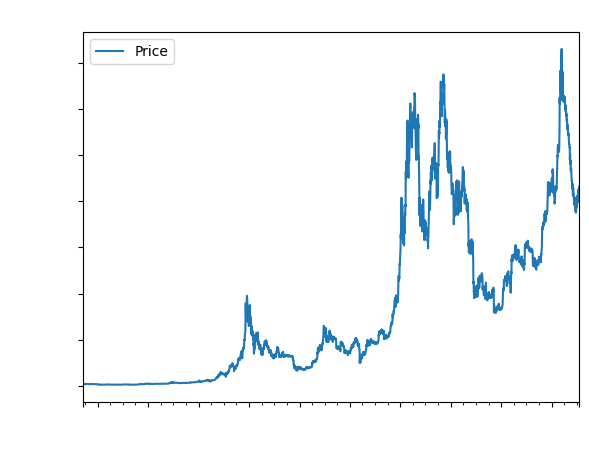

In [62]:
data_pytorch.plot(x='Date', y='Price')
plt.xlabel("Date", color='white')
plt.xticks(color='white')  # Change tick color to 'green'
plt.ylabel('Loss', color = 'white')
plt.yticks(color='white')  # Change tick color to 'green'
plt.title("Giá BTC từ 4-8/2024(1,50,5,120)", color='white')
plt.ylabel('USD')
plt.savefig('all_lstm(1,50,3,120).png', dpi=300, bbox_inches='tight', transparent=True);